# Import

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
tfds = tf.data.Dataset
print('TF Version = %s'%(tf.__version__))

TensorFlow 2.x selected.
TF Version = 2.1.0


In [0]:
!pip install -q --upgrade tensorflow-probability

In [3]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
print('TFP Version =%s'%(tfp.__version__))

TFP Version =0.9.0


In [4]:
import tensorflow
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import tensorflow.keras.datasets as datasets
import sys
import time
import contextlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline
print('TF Keras Version = %s'%(tfk.__version__))

TF Keras Version = 2.2.4-tf


# Preprocessing

## Data Generation

In [0]:
class ClockwiseSprial(tfk.Model):
  def __init__(self):
    super(ClockwiseSprial, self).__init__()
    self._W = tf.constant([[-0.08, -1.2], [0.3, -0.08]])

  def call(self, t, x):
    return tf.matmul(x, self._W)


class AntiClockwiseSprial(tfk.Model):
  def __init__(self):
    super(AntiClockwiseSprial, self).__init__()
    self._W = tf.constant([[-0.10, 1.0], [-0.2, -0.10]])

  def call(self, t, x):
    return tf.matmul(x, self._W)

In [0]:
MAXLEN = 101
TIME_GRIDS = np.linspace(0., 20., MAXLEN)

def generate_sample_set(model=AntiClockwiseSprial(),
                        sample_size=100, 
                        scale_of_init_state=3., 
                        scale_of_noise=0.05, 
                        solver=tfp.math.ode.DormandPrince(atol=1e-5)):
  
  # Specify the initial condition
  y0 = tf.Variable(
      np.random.uniform(low=-scale_of_init_state, 
                        high=scale_of_init_state, 
                        size=(sample_size,2)), 
      dtype=tf.float32)
  
  # Solve ODE
  times, states, _, _ = solver.solve(ode_fn=model, initial_time=0., initial_state=y0, solution_times=TIME_GRIDS)
  states = tf.transpose(states, perm=[1,0,2])
  
  # Add noise
  noise = np.random.normal(scale=scale_of_noise, size=states.shape)
  states = states + noise

  # Reshape times
  times = tf.reshape(times, (-1,1))
  times = tf.broadcast_to(times, states.shape[0:2]+(1,))
  
  return tf.concat([times, states], axis=-1)

In [0]:
NUM_EACH_SPIRALS = 1500
np.random.seed(0)

x1 = generate_sample_set(model=AntiClockwiseSprial(), sample_size=NUM_EACH_SPIRALS)
x2 = generate_sample_set(model=ClockwiseSprial(), sample_size=NUM_EACH_SPIRALS)
X_train = tf.concat([x1,x2], axis=0)

## Plot

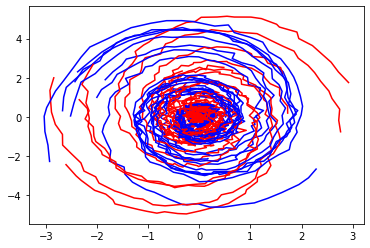

In [8]:
for i in range(0, 15):
    y = X_train[i].numpy()
    plt.plot(y[:,1], y[:,2], c='r')
    y = X_train[i+NUM_EACH_SPIRALS].numpy()
    plt.plot(y[:,1], y[:,2], c='b')
plt.show()

## Pipeline

In [0]:
BATCH_SIZE = 300

X_train = tfds.from_tensor_slices(X_train)
X_train = X_train.shuffle(buffer_size=2*NUM_EACH_SPIRALS, seed=0, reshuffle_each_iteration=True)
X_train = X_train.batch(BATCH_SIZE, drop_remainder=True)

# Model

## Encoder

In [0]:
class Encoder(tfk.Model):
  
  def __init__(self, latent_dim=4, maxlen=MAXLEN, hidden_units=25):
    super(Encoder, self).__init__()
    self._rnn = tfkl.SimpleRNN(hidden_units, activation='tanh', go_backwards=True, input_shape=(maxlen,3))
    self._mu = tfkl.Dense(latent_dim, activation=None)
    self._logvar = tfkl.Dense(latent_dim, activation=None)
  
  def call(self, x):
    x = self._rnn(x)
    mu = self._mu(x)
    logvar = self._logvar(x)
    return mu, logvar

## MLP for ODE

In [0]:
NUM_HIDDEN_UNITS = 48
NUM_HIDDEN_LAYERS = 2

class MLP_ODE(tfk.Model):

  def __init__(self, latent_dim=4):
    super(MLP_ODE, self).__init__()
    self._layers = [tfkl.Dense(NUM_HIDDEN_UNITS, 'tanh') for _ in range(NUM_HIDDEN_LAYERS)]
    self._layers.append(tfkl.Dense(latent_dim, activation=None))
  
  def call(self, t, inputs):
    x = inputs # autonomous system
    for l in self._layers: x = l(x)
    return x

## Decoder

In [0]:
class Decoder(tfk.Model):

  def __init__(self, latent_dim=4, output_dim=2, hidden_dim=20, atol=1e-5):
    super(Decoder, self).__init__()
    self._latent_dim = latent_dim
    self._output_dim = output_dim
    
    self._ode_fn = MLP_ODE(self._latent_dim)
    self._solver = tfp.math.ode.DormandPrince(atol=atol)
    
    self._hidden_layer = tfkl.Dense(hidden_dim, activation='tanh')
    self._mu = tfkl.Dense(self._output_dim, activation=None)
    self._logvar = tfkl.Dense(self._output_dim, activation=None)


  def call(self, z0, t=TIME_GRIDS, t0=0.):

    # Calc paths in latent space
    zk = self._calc_paths_in_latent_space(z0, t, t0)
    
    # Reshape zk to apply the "same" NN to each sample
    _shape = zk.shape[0:2] # = (batch_dim, time_dim)
    zk = tf.reshape(zk, (-1, self._latent_dim))
    
    # Apply the NN
    zk = self._hidden_layer(zk)
    mu = self._mu(zk)
    logvar = self._logvar(zk)
    
    # Return the parameters with reshaping
    output_shape = _shape + (self._output_dim,)
    
    return tf.reshape(mu, output_shape), tf.reshape(logvar, output_shape)
  

  def _calc_paths_in_latent_space(self, z0, t=TIME_GRIDS, t0=0.):
    _, zk, _, _ = self._solver.solve(self._ode_fn, initial_time=t0, initial_state=z0, solution_times=t)
    zk = tf.transpose(zk, perm=[1,0,2]) # exchange the first axis with the second one
    return zk

## VAE

In [0]:
LOG2PI = tf.math.log(2.*np.pi)
LATENT_DIM = 4
OUTPUT_DIM = 2

class VAE(tfk.Model):
  def __init__(self, atol=1e-5):
    super(VAE, self).__init__()
    self._encoder = Encoder(latent_dim=LATENT_DIM)
    self._decoder = Decoder(latent_dim=LATENT_DIM, output_dim=OUTPUT_DIM, atol=atol)
  
  def encode(self, x):
    return self._encoder(x)
  
  @tf.function
  def reparameterize(self, mu, logvar):
    eps = tf.random.normal(shape=mu.shape)
    return eps * tf.exp(logvar * .5) + mu
  
  def encode_and_reparametrize(self, x):
    mu, logvar = self.encode(x)
    return self.reparameterize(mu, logvar)
  
  def decode(self, z0, t=TIME_GRIDS, t0=0.):
    return self._decoder(z0, t, t0)
  
  def decode_and_reparametrize(self, z0, t, t0):
    mu, logvar = self.decode(z0, t, t0)
    return self.reparameterize(mu, logvar)

  def calc_paths_in_latent_space(self, z0, t, t0):
    return self._decoder._calc_paths_in_latent_space(z0, t, t0)

  @tf.function
  def log_normal_pdf(self, samples, mu, logvar):
    return tf.reduce_sum( -.5 * ((samples-mu)**2. * tf.exp(-logvar) + logvar + LOG2PI), axis=-1)

# Train

## Utils

In [0]:
@contextlib.contextmanager
def measure_time():
  start = time.time()
  try:
    yield
  finally:
    elapsed = time.time() - start
    print("\nElapsed Time %f [sec]"%(elapsed))

@contextlib.contextmanager
def overwriting_stdout():
  org_write = sys.stdout.write
  def overwrite(text):
    org_write("\r%s" % text)
    sys.stdout.flush()
  sys.stdout.write = overwrite
  try:
    yield
  finally:
    sys.stdout.write = org_write

## Loss

In [0]:
def calc_loss(vae, x):
  # Encode with sampling
  mu_z0, logvar_z0 = vae.encode(x)
  z0 = vae.reparameterize(mu_z0, logvar_z0)
  
  # Decode
  mu_x, logvar_x = vae.decode(z0)
  
  # Calc reconstruction error
  logpx_z = vae.log_normal_pdf(x[:,:,1:], mu_x, logvar_x) # x[:,:,0] is time (t)
  logpx_z = tf.reduce_sum(logpx_z, -1) # sum log_prob along time axis
  
  # Calc KL divergence
  logpz = vae.log_normal_pdf(z0, 0., 0.) # prior
  logqz_x = vae.log_normal_pdf(z0, mu_z0, logvar_z0) # approx posterior
  kl_div = logqz_x - logpz

  # Calc negative ELBO
  return tf.reduce_mean(-logpx_z + kl_div) # mean -elbo along batch axis

## Optimization

In [0]:
vae = VAE(atol=1e-5)
optimizer = tfk.optimizers.Adam(1e-3)

In [17]:
@tf.function
def train_step(vae, x, optimizer):
  with tf.GradientTape() as tape:
    loss = calc_loss(vae, x)
  variables = tape.watched_variables()
  grads = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(grads, variables))
  return loss

def train(vae, optimizer, n_epochs):
  losses = []
  for epoch in range(n_epochs):
    loss = [ train_step(vae, x, optimizer) for x in X_train ]
    loss = sum(loss)/len(loss) 
    sys.stdout.write('epoch %i: train loss = %f' % (epoch+1, loss))
    losses.append(loss)
  return losses


NUM_EPOCHS = 2500

with measure_time(), overwriting_stdout():
  train_loss = train(vae, optimizer, NUM_EPOCHS+1)

epoch 2501: train loss = -277.236877
Elapsed Time 31656.763023 [sec]


Text(0, 0.5, 'Epoch')

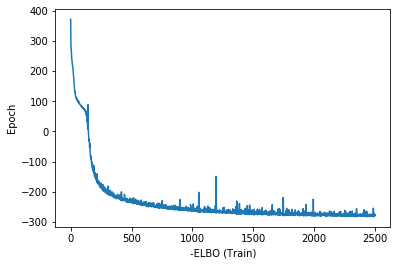

In [18]:
plt.plot(train_loss)
plt.xlabel('-ELBO (Train)')
plt.ylabel('Epoch')

# Results

## Extrapolation

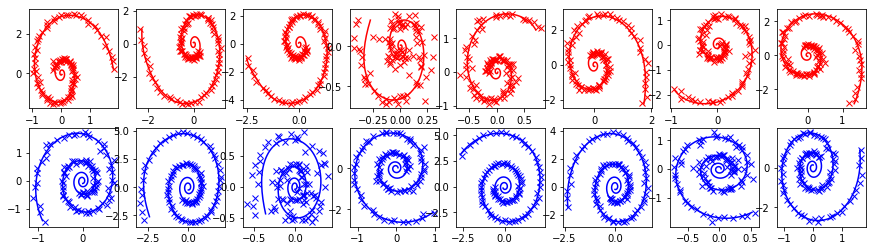

In [19]:
n = 8
fig, axes = plt.subplots(2, n, figsize=[15,4])
np.random.seed(999)

for i, model in enumerate([AntiClockwiseSprial(), ClockwiseSprial()]):
  c = 'r' if i == 0 else 'b'

  # Generate samples and transform them through VAE
  xs = generate_sample_set(model=model, sample_size=n)
  zs = vae.encode_and_reparametrize(xs)
  mu, _ = vae.decode(zs, t=np.linspace(0., 40., 401), t0=0.)

  xs = xs.numpy().reshape(n, -1, 3) # the first element is time
  mu = mu.numpy().reshape(n, -1, 2)
  
  for ax, x, x_hat in zip(axes[i,:], xs, mu):
    ax.plot(x[:,1], x[:,2], 'x', color=c)
    ax.plot(x_hat[:,0], x_hat[:,1], '-', color=c)

## Latent Space

[]

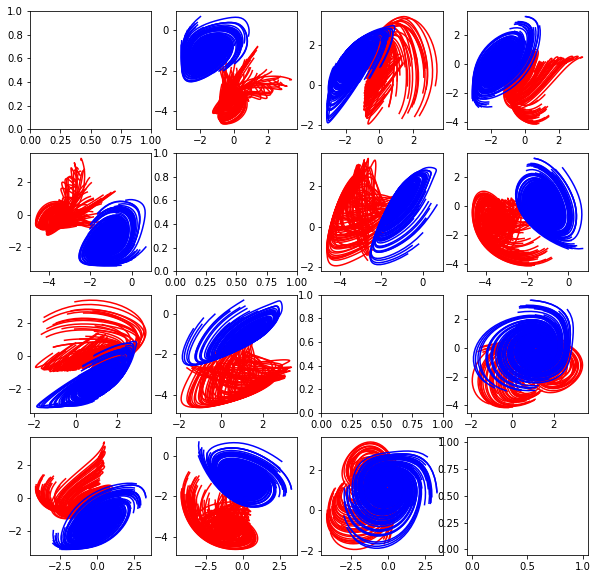

In [20]:
n = 100
np.random.seed(999)
fig, axes = plt.subplots(4,4,figsize=[10,10])

for i, model in enumerate([AntiClockwiseSprial(), ClockwiseSprial()]):
  c = 'r' if i == 0 else 'b'
  xs = generate_sample_set(model=model, sample_size=n)
  z0, _ = vae.encode(xs)
  zs = vae.calc_paths_in_latent_space(z0, t=TIME_GRIDS, t0=TIME_GRIDS[0])

  for first_dim in range(4):
    for second_dim in range(4):
      if first_dim == second_dim: continue
      ax = axes[first_dim, second_dim]
      for z in zs: ax.plot(z[:, first_dim], z[:, second_dim], c=c)
plt.plot()

# References

1. https://arxiv.org/abs/1806.07366
1. https://arxiv.org/abs/1810.01367